# Example Notebook for making performance and accuracy benchmarking figure

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, '../')

import blink

import pandas as pd
import numpy as np
import scipy
from scipy import sparse as sp

from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# Run BLINK on 1 million comparisons

In [2]:
spectra = blink.open_msms_file('./small.mgf').spectrum.tolist()

S = blink.discretize_spectra(spectra,expand=True)

N = blink.network_kernel(S['mzi'].shape[1], S['mzi'].shape[1])

blink_score = S['mzi'].dot(N).dot(S['mzi'].T)
blink_matches = S['mzc'].dot(N).dot(S['mzc'].T)

# Load Precomputed MatchMS Greedy Cosine for Same comparisons

In [3]:
sm = sp.load_npz('./matchms_small.npz')
matchms_score, matchms_matches = sm.real, sm.imag

# Load Precomputed Compute timing for various numbers of compariosns for MatchMS and BLINK

In [4]:
benchmark_df = pd.read_csv('./blink_benchmark.csv').groupby(['comparisons', 'algorithm']).median()

# Generate Figure in Manuscript

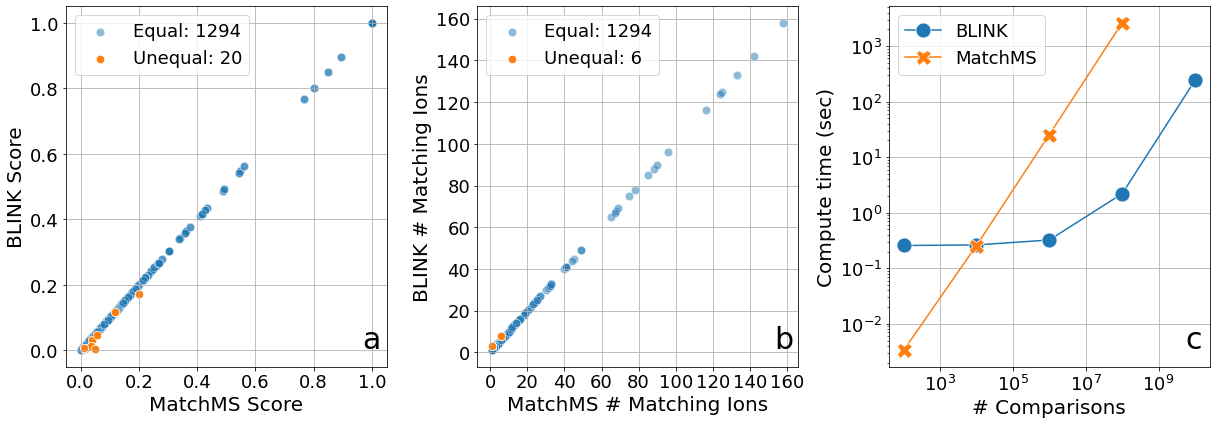

In [5]:
%matplotlib inline
x =matchms_score.toarray().flatten()
y = blink_score.toarray().flatten()
x,y = x[(x>0)&(y>0)], y[(x>0)&(y>0)]


fig, ax = plt.subplots(figsize=(17, 6),nrows=1,ncols=3)
ax = ax.flatten()
sns.scatterplot(x=x, y=y, s=70, label='Equal: {}'.format(len(x)), alpha=.5,ax=ax[0])
x,y = x[(y+1e-3<x)|(x<y-1e-3)], y[(y+1e-3<x)|(x<y-1e-3)]
sns.scatterplot(x=x, y=y, s=70, label='Unequal: {}'.format(len(x)),ax=ax[0])
ax[0].set_xlabel('MatchMS Score',fontsize=20)
ax[0].set_ylabel('BLINK Score',fontsize=20)


y = matchms_matches.toarray().flatten()
x = blink_matches.toarray().flatten()
x,y = x[(x>0)&(y>0)], y[(x>0)&(y>0)]

sns.scatterplot(x=x, y=y, s=70, label='Equal: {}'.format(len(x)), alpha=.5,ax=ax[1])
x,y = x[(y+1<x)|(x<y-1)], y[(y+1<x)|(x<y-1)]
sns.scatterplot(x=x, y=y, s=70, label='Unequal: {}'.format(len(x)),ax=ax[1])
ax[1].set_xlabel('MatchMS # Matching Ions',fontsize=20)
ax[1].set_ylabel('BLINK # Matching Ions',fontsize=20)

 
sns.lineplot(data=benchmark_df, x='comparisons', y='seconds', 
             hue='algorithm', style='algorithm', 
             markers=True, dashes=False,ax=ax[2],markersize=15)

ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_ylabel('Compute time (sec)',fontsize=20)
ax[2].set_xlabel('# Comparisons',fontsize=20)

for i,a in enumerate(ax):
    a.grid()
    if i==2:
        a.legend(fontsize=18,labels=['BLINK','MatchMS'])
    else:
        a.legend(fontsize=18,loc='upper left')
    
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontsize(18)
    a.text(0.925,0.05,chr(97+i),fontsize=30,transform=a.transAxes)

plt.tight_layout()
plt.show()

fig.savefig('accuracy_benchmarking.pdf')

In [6]:
benchmark_df.reset_index(inplace=True)
timing_df = pd.merge(benchmark_df[benchmark_df['algorithm']=='blink'].add_suffix('_blink'),
         benchmark_df[benchmark_df['algorithm']=='matchms'].add_suffix('_matchms'),
         left_on='comparisons_blink',
         right_on='comparisons_matchms',
         how='inner')
timing_df.head()

,comparisons_blink,algorithm_blink,seconds_blink,comparisons_matchms,algorithm_matchms,seconds_matchms
0,1.000000e+02,blink,0.257273,1.000000e+02,matchms,0.003334
1,1.000000e+04,blink,0.263390,1.000000e+04,matchms,0.257114
2,1.000000e+06,blink,0.323112,1.000000e+06,matchms,25.491312
3,1.000000e+08,blink,2.207324,1.000000e+08,matchms,2631.954724
4,1.000000e+10,blink,242.139770,1.000000e+10,matchms,NaN


In [7]:
timing_df['seconds_matchms']/timing_df['seconds_blink']

0       0.012960
1       0.976172
2      78.893121
3    1192.373695
4            NaN
dtype: float64